## Import

In [1]:
import gtsam
from gtsam.utils import plot as gtsam_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import open3d as o3d
from tqdm import tqdm
import time
import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load Data

In [2]:
# read the factor graph from cvs file
select = "odom"

base_path = "/media/baymax/1A52-86C0/new"

df_1_gt = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/gt/1.csv', sep=" ", header=None)
df_2_gt = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/gt/2.csv', sep=" ", header=None)
df_3_gt = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/gt/3.csv', sep=" ", header=None)
df_4_gt = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/gt/4.csv', sep=" ", header=None)

df_1 = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/{select}/1.csv', sep =" ", header=None)
df_2 = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/{select}/2.csv', sep =" ", header=None)
df_3 = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/{select}/3.csv', sep =" ", header=None)
df_4 = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/{select}/4.csv', sep =" ", header=None)

In [3]:
# convert to numpy array
arr_1_gt = df_1_gt.to_numpy()
arr_2_gt = df_2_gt.to_numpy()
arr_3_gt = df_3_gt.to_numpy()
arr_4_gt = df_4_gt.to_numpy()

arr_1 = df_1.to_numpy()
arr_2 = df_2.to_numpy()
arr_3 = df_3.to_numpy()
arr_4 = df_4.to_numpy()

In [4]:
print(arr_1_gt.shape)
print(arr_2_gt.shape)
print(arr_3_gt.shape)
print(arr_4_gt.shape)

print(arr_1.shape)
print(arr_2.shape)
print(arr_3.shape)
print(arr_4.shape)

(491, 8)
(314, 8)
(188, 8)
(424, 8)
(491, 8)
(314, 8)
(188, 8)
(424, 8)


In [5]:
i = 0
pose = gtsam.Pose3(
    gtsam.Rot3.Quaternion(
        arr_1[i][7], arr_1[i][4], arr_1[i][5], arr_1[i][6]
    ),
    gtsam.Point3(arr_1[i][1], arr_1[i][2], arr_1[i][3]),
)
print(pose.rotation)

<bound method PyCapsule.rotation of R: [
	1, -8.267e-05, 0;
	8.267e-05, 1, 0;
	0, 0, 1
]
t: 2.91004e-05 2.39909e-09           0
>


In [6]:
# save poses in gt_estimate

gt_estimate = gtsam.Values()
for i in range(len(arr_1_gt)):
    pose = gtsam.Pose3(
        gtsam.Rot3.Quaternion(
            arr_1_gt[i][7], arr_1_gt[i][4], arr_1_gt[i][5], arr_1_gt[i][6]
        ),
        gtsam.Point3(arr_1_gt[i][1], arr_1_gt[i][2], arr_1_gt[i][3]),
    )
    gt_estimate.insert(gtsam.symbol("a", i), pose)

for i in range(len(arr_2_gt)):
    pose = gtsam.Pose3(
        gtsam.Rot3.Quaternion(
            arr_2_gt[i][7], arr_2_gt[i][4], arr_2_gt[i][5], arr_2_gt[i][6]
        ),
        gtsam.Point3(arr_2_gt[i][1], arr_2_gt[i][2], arr_2_gt[i][3]),
    )
    gt_estimate.insert(gtsam.symbol("b", i), pose)

for i in range(len(arr_3_gt)):
    pose = gtsam.Pose3(
        gtsam.Rot3.Quaternion(
            arr_3_gt[i][7], arr_3_gt[i][4], arr_3_gt[i][5], arr_3_gt[i][6]
        ),
        gtsam.Point3(arr_3_gt[i][1], arr_3_gt[i][2], arr_3_gt[i][3]),
    )
    gt_estimate.insert(gtsam.symbol("c", i), pose)

for i in range(len(arr_4_gt)):
    pose = gtsam.Pose3(
        gtsam.Rot3.Quaternion(
            arr_4_gt[i][7], arr_4_gt[i][4], arr_4_gt[i][5], arr_4_gt[i][6]
        ),
        gtsam.Point3(arr_4_gt[i][1], arr_4_gt[i][2], arr_4_gt[i][3]),
    )
    gt_estimate.insert(gtsam.symbol("d", i), pose)

## Adding Odometry in Graph

In [7]:
graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# add prior factor
prior_noise = gtsam.noiseModel.Diagonal.Sigmas([0, 0, 0, 0, 0, 0])
prior_noise = gtsam.noiseModel.Diagonal.Sigmas([1e-9, 1e-9, 1e-9, 1e-9, 1e-9, 1e-9])
noise_odom = gtsam.noiseModel.Diagonal.Sigmas([0.01, 0.01, 0.01, 0.05, 0.05, 0.05])
# noise_odom = gtsam.noiseModel.Diagonal.Sigmas([1e-9, 1e-9, 1e-9, 1e-9, 1e-9, 1e-9])
noise_loop = gtsam.noiseModel.Diagonal.Sigmas(
    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
)

# setting arbritary local frames
tf_1 = gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(0, 0, 100))
tf_2 = gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(0, 100, 0))
tf_3 = gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(100, 0, 0))
tf_4 = gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(100, 0, 0))

# Adding Prior Factor
graph.add(
    gtsam.PriorFactorPose3(
        gtsam.symbol("a", 0),
        gtsam.Pose3(
            gtsam.Rot3.Quaternion(arr_1[0][7], arr_1[0][4], arr_1[0][5], arr_1[0][6]),
            gtsam.Point3(arr_1[0][1], arr_1[0][2], arr_1[0][3]),
        ),
        prior_noise,
    )
)

#  GTSAM ROT QUAT INPUT is qw, wx, qy, qz

for i in range(len(arr_1) - 1):
    key = gtsam.symbol("a", i)
    next_key = gtsam.symbol("a", i + 1)
    pose = gtsam.Pose3(
        gtsam.Rot3.Quaternion(arr_1[i][7], arr_1[i][4], arr_1[i][5], arr_1[i][6]),
        gtsam.Point3(arr_1[i][1], arr_1[i][2], arr_1[i][3]),
    )
    pose_next = gtsam.Pose3(
        gtsam.Rot3.Quaternion(
            arr_1[i + 1][7], arr_1[i + 1][4], arr_1[i + 1][5], arr_1[i + 1][6]
        ),
        gtsam.Point3(arr_1[i + 1][1], arr_1[i + 1][2], arr_1[i + 1][3]),
    )
    graph.add(
        gtsam.BetweenFactorPose3(key, next_key, pose.between(pose_next), noise_odom)
    )
    if i == 0:
        initial_estimate.insert(key, tf_1 * pose)
    initial_estimate.insert(next_key, tf_1 * pose_next)

for i in range(len(arr_2) - 1):
    key = gtsam.symbol("b", i)
    next_key = gtsam.symbol("b", i + 1)
    pose = gtsam.Pose3(
        gtsam.Rot3.Quaternion(arr_2[i][7], arr_2[i][4], arr_2[i][5], arr_2[i][6]),
        gtsam.Point3(arr_2[i][1], arr_2[i][2], arr_2[i][3]),
    )
    pose_next = gtsam.Pose3(
        gtsam.Rot3.Quaternion(
            arr_2[i + 1][7], arr_2[i + 1][4], arr_2[i + 1][5], arr_2[i + 1][6]
        ),
        gtsam.Point3(arr_2[i + 1][1], arr_2[i + 1][2], arr_2[i + 1][3]),
    )
    graph.add(
        gtsam.BetweenFactorPose3(key, next_key, pose.between(pose_next), noise_odom)
    )
    if i == 0:
        initial_estimate.insert(key, tf_2 * pose)
        # initial_estimate.insert(key ,gtsam.Pose3())
    initial_estimate.insert(next_key, tf_2 * pose_next)
    # initial_estimate.insert(next_key, gtsam.Pose3())

for i in range(len(arr_3) - 1):
    key = gtsam.symbol("c", i)
    next_key = gtsam.symbol("c", i + 1)
    pose = gtsam.Pose3(
        gtsam.Rot3.Quaternion(arr_3[i][7], arr_3[i][4], arr_3[i][5], arr_3[i][6]),
        gtsam.Point3(arr_3[i][1], arr_3[i][2], arr_3[i][3]),
    )
    pose_next = gtsam.Pose3(
        gtsam.Rot3.Quaternion(
            arr_3[i + 1][7], arr_3[i + 1][4], arr_3[i + 1][5], arr_3[i + 1][6]
        ),
        gtsam.Point3(arr_3[i + 1][1], arr_3[i + 1][2], arr_3[i + 1][3]),
    )
    graph.add(
        gtsam.BetweenFactorPose3(key, next_key, pose.between(pose_next), noise_odom)
    )
    if i == 0:
        initial_estimate.insert(key, tf_3 * pose)
        # initial_estimate.insert(key, gtsam.Pose3())
    initial_estimate.insert(next_key, tf_3 * pose_next)
    # initial_estimate.insert(next_key, gtsam.Pose3())

for i in range(len(arr_4) - 1):
    key = gtsam.symbol("d", i)
    next_key = gtsam.symbol("d", i + 1)
    pose = gtsam.Pose3(
        gtsam.Rot3.Quaternion(arr_4[i][7], arr_4[i][4], arr_4[i][5], arr_4[i][6]),
        gtsam.Point3(arr_4[i][1], arr_4[i][2], arr_4[i][3]),
    )
    pose_next = gtsam.Pose3(
        gtsam.Rot3.Quaternion(
            arr_4[i + 1][7], arr_4[i + 1][4], arr_4[i + 1][5], arr_4[i + 1][6]
        ),
        gtsam.Point3(arr_4[i + 1][1], arr_4[i + 1][2], arr_4[i + 1][3]),
    )
    graph.add(
        gtsam.BetweenFactorPose3(key, next_key, pose.between(pose_next), noise_odom)
    )
    if i == 0:
        initial_estimate.insert(key, tf_4 * pose)
        # initial_estimate.insert(key, gtsam.Pose3())
    initial_estimate.insert(next_key, tf_4 * pose_next)
    # initial_estimate.insert(next_key, gtsam.Pose3())

## Util

In [8]:
def create_se3_transform(tx, ty, yaw):
    """
    Create a 4x4 SE(3) transformation matrix.

    Parameters:
    - yaw: Yaw angle in radians
    - translation: (tx, ty) translation components in the XY plane

    Returns:
    - transform_matrix: 4x4 homogeneous transformation matrix
    """
    cos_theta = np.cos(yaw)
    sin_theta = np.sin(yaw)

    transform_matrix = np.array([
        [cos_theta, -sin_theta, 0, tx],
        [sin_theta, cos_theta, 0, ty],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    return transform_matrix

def decompose_transform_matrix(transform_matrix):
    """
    Decompose a 4x4 homogeneous transformation matrix into a 9-element rotation matrix and a 3-element translation vector.

    Parameters:
    - transform_matrix: 4x4 homogeneous transformation matrix

    Returns:
    - rotation_matrix_9: 1D array of length 9 representing the rotation matrix
    - translation_vector: (tx, ty, tz) translation vector
    """
    
    rotation_matrix_3x3 = transform_matrix[:3, :3]
    translation_vector = transform_matrix[:3, 3]

    return rotation_matrix_3x3, translation_vector

def get_pcd(arr):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(arr[:, 0:3])
    return pcd

def draw_registration_result(source, target, transformation, display_time=0.6):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(source_temp)
    vis.add_geometry(target_temp)
    vis.poll_events()
    vis.update_renderer()

    time.sleep(display_time)

    vis.destroy_window()
    # o3d.visualization.draw_geometries([source_temp, target_temp], point_show_normal = True)

In [9]:
# add ICP loop closures here
symbol_dict = {1: "a", 2: "b", 3: "c", 4: "d"}

# base_link to velodyne transform
tf_sen = gtsam.Pose3(
    gtsam.Rot3(1, 0, 0, 0, 1, 0, 0, 0, 1), gtsam.Point3(0.0812, 0.0, 0.409)
)

## Adding Loops

In [10]:
# # loop registration using ICP given loops detection is already done

df_train = pd.read_csv("/media/baymax/1A52-86C0/new/detected_loops/trained_loops.txt")

pcd_basepath = "/media/baymax/1A52-86C0/new/detected_loops/pose_data/sync/pcd"
novel = set()
view_icp = False
j = 0
# # print(len(df_train))
for i in tqdm(range(len(df_train))):
    initial = df_train.iloc[i, 0].split(".")[0]
    final = df_train.iloc[i, 1].split(".")[0]

    if (
        initial[0] == final[0]
        and i % 100 == 0
        and i > 3000
        and abs(int(initial[2:].split("_")[0]) - int(final[2:].split("_")[0]) > 1)
    ) or (initial[0] != final[0] and i % 3 == 0):
        init_pcd = np.load(f"{pcd_basepath}/{initial}.npy")
        final_pcd = np.load(f"{pcd_basepath}/{final}.npy")

        init_pcd = init_pcd[init_pcd[:, 2] > 0.005]
        final_pcd = final_pcd[final_pcd[:, 2] > 0.005]

        init_pcd = get_pcd(init_pcd)
        final_pcd = get_pcd(final_pcd)

        init_oc = init_pcd
        final_oc = final_pcd

        init_pcd = init_pcd.voxel_down_sample(voxel_size=0.05)
        final_pcd = final_pcd.voxel_down_sample(voxel_size=0.05)

        init_pcd.estimate_normals(
            search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=500)
        )
        final_pcd.estimate_normals(
            search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=500)
        )

        source_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
            init_pcd, o3d.geometry.KDTreeSearchParamHybrid(radius=5, max_nn=100)
        )

        target_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
            final_pcd, o3d.geometry.KDTreeSearchParamHybrid(radius=5, max_nn=100)
        )
        j =j+1
        if j%20 < 17:
            ransac_result = (
                o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
                    init_pcd,
                    final_pcd,
                    source_fpfh,
                    target_fpfh,
                    o3d.pipelines.registration.FastGlobalRegistrationOption(
                        maximum_correspondence_distance=0.05
                    ),
                )
            )

            tf = o3d.pipelines.registration.registration_icp(
                init_pcd,
                final_pcd,
                0.0001,
                np.array(ransac_result.transformation),
                o3d.pipelines.registration.TransformationEstimationPointToPlane(),
                o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=10000),
            )
        else:
            tf = o3d.pipelines.registration.registration_icp(
                init_oc,
                final_oc,
                0.01,
                np.eye(4),
                o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
                o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=10000),
            )

        rot, t = decompose_transform_matrix(tf.transformation)

        if abs(np.linalg.det(rot) - 1) > 0.1:
            print("wrong rot", abs(np.linalg.det(rot) - 1))

        r = rot.flatten()

        loop_tf = gtsam.Pose3(
            gtsam.Rot3(r[0], r[1], r[2], r[3], r[4], r[5], r[6], r[7], r[8]),
            gtsam.Point3(t[0], t[1], t[2]),
        )

        # print(
        #     symbol_dict[int(initial[0])],
        #     int(initial[2:].split("_")[0]) - 1,
        #     symbol_dict[int(final[0])],
        #     int(final[2:].split("_")[0]) - 1,
        # )

        novel.add(f"{initial[0]},{final[0]}")

        # vis tf in open3d
        # o3d.visualization.draw_geometries([init_pcd, tf_pcd])
        # if (initial[0] == "3" and final[0] == "3") or (
        #     initial[0] == "3" and final[0] == "3"
        # ):
        #     draw_registration_result(init_pcd, final_pcd, tf.transformation)
        if view_icp == True:
            draw_registration_result(init_oc, final_oc, tf.transformation)

        # source_temp = copy.deepcopy(init_pcd)
        # target_temp = copy.deepcopy(final_pcd)
        # source_temp.paint_uniform_color([1, 0.706, 0])
        # target_temp.paint_uniform_color([0, 0.651, 0.929])
        # source_temp.transform(tf.transformation)

        # # Get the corresponding points
        # source_points = np.asarray(init_pcd.points)[np.array(ransac_result.correspondence_set)[:, 0]]
        # target_points = np.asarray(final_pcd.points)[np.array(ransac_result.correspondence_set)[:, 1]]

        # Create lines between corresponding points
        # lines = []
        # for i in range(len(source_points)):
        #     lines.append([source_points[i], target_points[i]])

        ## Convert lines to Open3D line set
        # line_set = o3d.geometry.LineSet()
        # line_set.points = o3d.utility.Vector3dVector(np.vstack(lines))
        ## print(np.vstack(lines).shape)
        # line_set.lines = o3d.utility.Vector2iVector(np.arange(2*len(lines)).reshape(-1, 2))

        # o3d.visualization.draw_geometries([init_pcd, final_pcd, line_set], point_show_normal = True, window_name="ICP")
        # o3d.visualization.draw_geometries([init_pcd, final_pcd], window_name=f"{initial} to {final}")

        ## Get the corresponding points
        # source_points = np.asarray(source_temp.points)[np.array(ransac_result.correspondence_set)[:, 0]]
        # target_points = np.asarray(target_temp.points)[np.array(ransac_result.correspondence_set)[:, 1]]

        # lines = []
        # for i in range(len(source_points)):
        #     lines.append([source_points[i], target_points[i]])

        ## Convert lines to Open3D line set
        # line_set = o3d.geometry.LineSet()
        # line_set.points = o3d.utility.Vector3dVector(np.vstack(lines))
        # # print(np.vstack(lines).shape)
        # line_set.lines = o3d.utility.Vector2iVector(np.arange(2*len(lines)).reshape(-1, 2))

        # o3d.visualization.draw_geometries([source_temp, target_temp, line_set], window_name="ICP")

        graph.add(
            gtsam.BetweenFactorPose3(
                gtsam.symbol(
                    symbol_dict[int(initial[0])], int(initial[2:].split("_")[0]) - 1
                ),
                gtsam.symbol(
                    symbol_dict[int(final[0])], int(final[2:].split("_")[0]) - 1
                ),
                tf_sen * loop_tf.inverse() * tf_sen.inverse(),
                noise_loop,
            )
        )

        ## ading gt loops for testing of pipeline before testing with icp loop closures
        # graph.add(
        #     gtsam.BetweenFactorPose3(
        #         gtsam.symbol(
        #             symbol_dict[int(initial[0])], int(initial[2:].split("_")[0]) - 1
        #         ),
        #         gtsam.symbol(
        #             symbol_dict[int(final[0])], int(final[2:].split("_")[0]) - 1
        #         ),
        #         gt_estimate.atPose3(
        #             gtsam.symbol(
        #                 symbol_dict[int(initial[0])], int(initial[2:].split("_")[0]) - 1
        #             )
        #         )
        #         .between(
        #             gt_estimate.atPose3(
        #                 gtsam.symbol(
        #                     symbol_dict[int(final[0])], int(final[2:].split("_")[0]) - 1
        #                 )
        #             )
        #         )
        #         .inverse(),
        #         noise_loop,
        #     )
        # )
        # print("gt",gt_estimate.atPose3(
        #             gtsam.symbol(
        #                 symbol_dict[int(initial[0])], int(initial[2:].split("_")[0]) - 1
        #             )
        #         ).between(
        #             gt_estimate.atPose3(
        #                 gtsam.symbol(
        #                     symbol_dict[int(final[0])], int(final[2:].split("_")[0]) - 1
        #                 )
        #             )
        #         ))
        # print(tf.transformation,"\n\n" ,rot, t)

print(novel)

  0%|          | 0/8183 [00:00<?, ?it/s]

100%|██████████| 8183/8183 [01:50<00:00, 73.96it/s]  

{'2,3', '1,2', '2,4', '3,4', '3,3'}


In [11]:
# df = pd.read_csv('/media/baymax/1A52-86C0/new/detected_loops/new_icp_loop.txt', delimiter=',', header=None)
# loops = df.to_numpy()

# for i in loops:
#     key = gtsam.symbol(symbol_dict[i[0]], int(i[1])-1)
#     key_next = gtsam.symbol(symbol_dict[i[2]], int(i[3])-1)
#     tf = create_se3_transform(i[4], i[5], i[6])
#     r,t = decompose_transform_matrix(tf)
#     pose = gtsam.Pose3(gtsam.Rot3(r), gtsam.Point3(t))
#     graph.add(graph.add(gtsam.BetweenFactorPose3(key, key_next, tf_sen*pose*tf_sen.inverse(), noise_loop)))

## Optimize

In [33]:
# set inliers (odometry edges)
inliers = gtsam.KeyVector()
for i in range(len(arr_1)+len(arr_2)+len(arr_3)+len(arr_4) - 4 + 1):
    inliers.append(i)

In [34]:
params_gauss = gtsam.GaussNewtonParams()
optimizer_gauss = gtsam.GaussNewtonOptimizer(graph, initial_estimate, params_gauss)
result_gauss = optimizer_gauss.optimize()

In [35]:
params_lm = gtsam.LevenbergMarquardtParams()
optimizer_lm = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params_lm)
result_lm = optimizer_lm.optimize()

In [36]:
paramsGncLm = gtsam.GncLMParams(params_lm)
paramsGncLm.setKnownInliers(inliers)
optimizer_gnc_lm = gtsam.GncLMOptimizer(graph, initial_estimate, paramsGncLm)
result_gnc_lm = optimizer_gnc_lm.optimize()


In [37]:
paramsGncGauss = gtsam.GncGaussNewtonParams()
paramsGncGauss.setKnownInliers(inliers)
optmizer_gnc_gauss = gtsam.GncGaussNewtonOptimizer(graph, initial_estimate, paramsGncGauss)
result_gnc_gauss = optmizer_gnc_gauss.optimize()

RuntimeError: 
Indeterminant linear system detected while working near variable
7133701809754865698 (Symbol: c34).

Thrown when a linear system is ill-posed.  The most common cause for this
error is having underconstrained variables.  Mathematically, the system is
underdetermined.  See the GTSAM Doxygen documentation at
http://borg.cc.gatech.edu/ on gtsam::IndeterminantLinearSystemException for
more information.

## Save Poses

In [38]:
# extract optimized poses into numpy array and save into csv file with same input format
save_folder = "optimized_gnc_lm"

poses_1 = []
poses_2 = []
poses_3 = []
poses_4 = []

for key in result_gnc_lm.keys():
    log = int(math.log10(key))
    key_ = int(key / (10 ** (log - 1)))
    if key_ == 69:
        poses_1.append(
            [
                int(key - gtsam.symbol("a", 0) + 1),
                result_gnc_lm.atPose3(key).x(),
                result_gnc_lm.atPose3(key).y(),
                result_gnc_lm.atPose3(key).z(),
                result_gnc_lm.atPose3(key).rotation().toQuaternion().x(),
                result_gnc_lm.atPose3(key).rotation().toQuaternion().y(),
                result_gnc_lm.atPose3(key).rotation().toQuaternion().z(),
                result_gnc_lm.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

    if key_ == 70:
        poses_2.append(
            [
                int(key - gtsam.symbol("b", 0) + 1),
                result_gnc_lm.atPose3(key).x(),
                result_gnc_lm.atPose3(key).y(),
                result_gnc_lm.atPose3(key).z(),
                result_gnc_lm.atPose3(key).rotation().toQuaternion().x(),
                result_gnc_lm.atPose3(key).rotation().toQuaternion().y(),
                result_gnc_lm.atPose3(key).rotation().toQuaternion().z(),
                result_gnc_lm.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

    if key_ == 71:
        poses_3.append(
            [
                int(key - gtsam.symbol("c", 0) + 1),
                result_gnc_lm.atPose3(key).x(),
                result_gnc_lm.atPose3(key).y(),
                result_gnc_lm.atPose3(key).z(),
                result_gnc_lm.atPose3(key).rotation().toQuaternion().x(),
                result_gnc_lm.atPose3(key).rotation().toQuaternion().y(),
                result_gnc_lm.atPose3(key).rotation().toQuaternion().z(),
                result_gnc_lm.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

    if key_ == 72:
        poses_4.append(
            [
                int(key - gtsam.symbol("d", 0) + 1),
                result_gnc_lm.atPose3(key).x(),
                result_gnc_lm.atPose3(key).y(),
                result_gnc_lm.atPose3(key).z(),
                result_gnc_lm.atPose3(key).rotation().toQuaternion().x(),
                result_gnc_lm.atPose3(key).rotation().toQuaternion().y(),
                result_gnc_lm.atPose3(key).rotation().toQuaternion().z(),
                result_gnc_lm.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

poses_1_np = np.array(poses_1)
poses_2_np = np.array(poses_2)
poses_3_np = np.array(poses_3)
poses_4_np = np.array(poses_4)


# save to csv
df_1 = pd.DataFrame(data=poses_1_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/1.csv"
df_1.to_csv(csv_file_path, sep=" ", index=False, header=False)

df_2 = pd.DataFrame(data=poses_2_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/2.csv"
df_2.to_csv(csv_file_path, sep=" ", index=False, header=False)

df_3 = pd.DataFrame(data=poses_3_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/3.csv"
df_3.to_csv(csv_file_path, sep=" ", index=False, header=False)

df_4 = pd.DataFrame(data=poses_4_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/4.csv"
df_4.to_csv(csv_file_path, sep=" ", index=False, header=False)

In [39]:
# extract optimized poses into numpy array and save into csv file with same input format
save_folder = "optimized_lm"

poses_1 = []
poses_2 = []
poses_3 = []
poses_4 = []

for key in result_lm.keys():
    log = int(math.log10(key))
    key_ = int(key / (10 ** (log - 1)))
    if key_ == 69:
        poses_1.append(
            [
                int(key - gtsam.symbol("a", 0) + 1),
                result_lm.atPose3(key).x(),
                result_lm.atPose3(key).y(),
                result_lm.atPose3(key).z(),
                result_lm.atPose3(key).rotation().toQuaternion().x(),
                result_lm.atPose3(key).rotation().toQuaternion().y(),
                result_lm.atPose3(key).rotation().toQuaternion().z(),
                result_lm.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

    if key_ == 70:
        poses_2.append(
            [
                int(key - gtsam.symbol("b", 0) + 1),
                result_lm.atPose3(key).x(),
                result_lm.atPose3(key).y(),
                result_lm.atPose3(key).z(),
                result_lm.atPose3(key).rotation().toQuaternion().x(),
                result_lm.atPose3(key).rotation().toQuaternion().y(),
                result_lm.atPose3(key).rotation().toQuaternion().z(),
                result_lm.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

    if key_ == 71:
        poses_3.append(
            [
                int(key - gtsam.symbol("c", 0) + 1),
                result_lm.atPose3(key).x(),
                result_lm.atPose3(key).y(),
                result_lm.atPose3(key).z(),
                result_lm.atPose3(key).rotation().toQuaternion().x(),
                result_lm.atPose3(key).rotation().toQuaternion().y(),
                result_lm.atPose3(key).rotation().toQuaternion().z(),
                result_lm.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

    if key_ == 72:
        poses_4.append(
            [
                int(key - gtsam.symbol("d", 0) + 1),
                result_lm.atPose3(key).x(),
                result_lm.atPose3(key).y(),
                result_lm.atPose3(key).z(),
                result_lm.atPose3(key).rotation().toQuaternion().x(),
                result_lm.atPose3(key).rotation().toQuaternion().y(),
                result_lm.atPose3(key).rotation().toQuaternion().z(),
                result_lm.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

poses_1_np = np.array(poses_1)
poses_2_np = np.array(poses_2)
poses_3_np = np.array(poses_3)
poses_4_np = np.array(poses_4)


# save to csv
df_1 = pd.DataFrame(data=poses_1_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/1.csv"
df_1.to_csv(csv_file_path, sep=" ", index=False, header=False)

df_2 = pd.DataFrame(data=poses_2_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/2.csv"
df_2.to_csv(csv_file_path, sep=" ", index=False, header=False)

df_3 = pd.DataFrame(data=poses_3_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/3.csv"
df_3.to_csv(csv_file_path, sep=" ", index=False, header=False)

df_4 = pd.DataFrame(data=poses_4_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/4.csv"
df_4.to_csv(csv_file_path, sep=" ", index=False, header=False)

In [40]:
# extract optimized poses into numpy array and save into csv file with same input format
save_folder = "optimized_gnc_gauss"

poses_1 = []
poses_2 = []
poses_3 = []
poses_4 = []

for key in result_gauss.keys():
    log = int(math.log10(key))
    key_ = int(key / (10 ** (log - 1)))
    if key_ == 69:
        poses_1.append(
            [
                int(key - gtsam.symbol("a", 0) + 1),
                result_gnc_gauss.atPose3(key).x(),
                result_gnc_gauss.atPose3(key).y(),
                result_gnc_gauss.atPose3(key).z(),
                result_gnc_gauss.atPose3(key).rotation().toQuaternion().x(),
                result_gnc_gauss.atPose3(key).rotation().toQuaternion().y(),
                result_gnc_gauss.atPose3(key).rotation().toQuaternion().z(),
                result_gnc_gauss.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

    if key_ == 70:
        poses_2.append(
            [
                int(key - gtsam.symbol("b", 0) + 1),
                result_gnc_gauss.atPose3(key).x(),
                result_gnc_gauss.atPose3(key).y(),
                result_gnc_gauss.atPose3(key).z(),
                result_gnc_gauss.atPose3(key).rotation().toQuaternion().x(),
                result_gnc_gauss.atPose3(key).rotation().toQuaternion().y(),
                result_gnc_gauss.atPose3(key).rotation().toQuaternion().z(),
                result_gnc_gauss.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

    if key_ == 71:
        poses_3.append(
            [
                int(key - gtsam.symbol("c", 0) + 1),
                result_gnc_gauss.atPose3(key).x(),
                result_gnc_gauss.atPose3(key).y(),
                result_gnc_gauss.atPose3(key).z(),
                result_gnc_gauss.atPose3(key).rotation().toQuaternion().x(),
                result_gnc_gauss.atPose3(key).rotation().toQuaternion().y(),
                result_gnc_gauss.atPose3(key).rotation().toQuaternion().z(),
                result_gnc_gauss.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

    if key_ == 72:
        poses_4.append(
            [
                int(key - gtsam.symbol("d", 0) + 1),
                result_gnc_gauss.atPose3(key).x(),
                result_gnc_gauss.atPose3(key).y(),
                result_gnc_gauss.atPose3(key).z(),
                result_gnc_gauss.atPose3(key).rotation().toQuaternion().x(),
                result_gnc_gauss.atPose3(key).rotation().toQuaternion().y(),
                result_gnc_gauss.atPose3(key).rotation().toQuaternion().z(),
                result_gnc_gauss.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

poses_1_np = np.array(poses_1)
poses_2_np = np.array(poses_2)
poses_3_np = np.array(poses_3)
poses_4_np = np.array(poses_4)


# save to csv
df_1 = pd.DataFrame(data=poses_1_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/1.csv"
df_1.to_csv(csv_file_path, sep=" ", index=False, header=False)

df_2 = pd.DataFrame(data=poses_2_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/2.csv"
df_2.to_csv(csv_file_path, sep=" ", index=False, header=False)

df_3 = pd.DataFrame(data=poses_3_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/3.csv"
df_3.to_csv(csv_file_path, sep=" ", index=False, header=False)

df_4 = pd.DataFrame(data=poses_4_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/4.csv"
df_4.to_csv(csv_file_path, sep=" ", index=False, header=False)

NameError: name 'result_gnc_gauss' is not defined

In [41]:
# extract optimized poses into numpy array and save into csv file with same input format
save_folder = "optimized_gauss"

poses_1 = []
poses_2 = []
poses_3 = []
poses_4 = []

for key in result_gauss.keys():
    log = int(math.log10(key))
    key_ = int(key / (10 ** (log - 1)))
    if key_ == 69:
        poses_1.append(
            [
                int(key - gtsam.symbol("a", 0) + 1),
                result_gauss.atPose3(key).x(),
                result_gauss.atPose3(key).y(),
                result_gauss.atPose3(key).z(),
                result_gauss.atPose3(key).rotation().toQuaternion().x(),
                result_gauss.atPose3(key).rotation().toQuaternion().y(),
                result_gauss.atPose3(key).rotation().toQuaternion().z(),
                result_gauss.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

    if key_ == 70:
        poses_2.append(
            [
                int(key - gtsam.symbol("b", 0) + 1),
                result_gauss.atPose3(key).x(),
                result_gauss.atPose3(key).y(),
                result_gauss.atPose3(key).z(),
                result_gauss.atPose3(key).rotation().toQuaternion().x(),
                result_gauss.atPose3(key).rotation().toQuaternion().y(),
                result_gauss.atPose3(key).rotation().toQuaternion().z(),
                result_gauss.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

    if key_ == 71:
        poses_3.append(
            [
                int(key - gtsam.symbol("c", 0) + 1),
                result_gauss.atPose3(key).x(),
                result_gauss.atPose3(key).y(),
                result_gauss.atPose3(key).z(),
                result_gauss.atPose3(key).rotation().toQuaternion().x(),
                result_gauss.atPose3(key).rotation().toQuaternion().y(),
                result_gauss.atPose3(key).rotation().toQuaternion().z(),
                result_gauss.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

    if key_ == 72:
        poses_4.append(
            [
                int(key - gtsam.symbol("d", 0) + 1),
                result_gauss.atPose3(key).x(),
                result_gauss.atPose3(key).y(),
                result_gauss.atPose3(key).z(),
                result_gauss.atPose3(key).rotation().toQuaternion().x(),
                result_gauss.atPose3(key).rotation().toQuaternion().y(),
                result_gauss.atPose3(key).rotation().toQuaternion().z(),
                result_gauss.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

poses_1_np = np.array(poses_1)
poses_2_np = np.array(poses_2)
poses_3_np = np.array(poses_3)
poses_4_np = np.array(poses_4)


# save to csv
df_1 = pd.DataFrame(data=poses_1_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/1.csv"
df_1.to_csv(csv_file_path, sep=" ", index=False, header=False)

df_2 = pd.DataFrame(data=poses_2_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/2.csv"
df_2.to_csv(csv_file_path, sep=" ", index=False, header=False)

df_3 = pd.DataFrame(data=poses_3_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/3.csv"
df_3.to_csv(csv_file_path, sep=" ", index=False, header=False)

df_4 = pd.DataFrame(data=poses_4_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/4.csv"
df_4.to_csv(csv_file_path, sep=" ", index=False, header=False)

In [42]:
# extract optimized poses into numpy array and save into csv file with same input format
save_folder = "combined"
Pose_lm = []
Pose_gnc_lm = []
Pose_gt = []
Pose_odom = []
Pose_gnc_gauss = []
Pose_gauss = []

for key in result_gauss.keys():
    Pose_gt.append(
        [
            int(key - gtsam.symbol("a", 0) + 1),
            gt_estimate.atPose3(key).x(),
            gt_estimate.atPose3(key).y(),
            gt_estimate.atPose3(key).z(),
            gt_estimate.atPose3(key).rotation().toQuaternion().x(),
            gt_estimate.atPose3(key).rotation().toQuaternion().y(),
            gt_estimate.atPose3(key).rotation().toQuaternion().z(),
            gt_estimate.atPose3(key).rotation().toQuaternion().w(),
        ]
    )
    Pose_odom.append(
        [
            int(key - gtsam.symbol("a", 0) + 1),
            initial_estimate.atPose3(key).x(),
            initial_estimate.atPose3(key).y(),
            initial_estimate.atPose3(key).z(),
            initial_estimate.atPose3(key).rotation().toQuaternion().x(),
            initial_estimate.atPose3(key).rotation().toQuaternion().y(),
            initial_estimate.atPose3(key).rotation().toQuaternion().z(),
            initial_estimate.atPose3(key).rotation().toQuaternion().w(),
        ]
    )

df_1 = pd.DataFrame(data=Pose_gt)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/combined_gt.csv"
df_1.to_csv(csv_file_path, sep=" ", index=False, header=False)

df_1 = pd.DataFrame(data=Pose_odom)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/combined_odom.csv"
df_1.to_csv(csv_file_path, sep=" ", index=False, header=False)

In [43]:
for key in result_lm.keys():
    Pose_lm.append(
        [
            int(key - gtsam.symbol("a", 0) + 1),
            result_lm.atPose3(key).x(),
            result_lm.atPose3(key).y(),
            result_lm.atPose3(key).z(),
            result_lm.atPose3(key).rotation().toQuaternion().x(),
            result_lm.atPose3(key).rotation().toQuaternion().y(),
            result_lm.atPose3(key).rotation().toQuaternion().z(),
            result_lm.atPose3(key).rotation().toQuaternion().w(),
        ]
    )

df_1 = pd.DataFrame(data=Pose_lm)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/combined_lm.csv"
df_1.to_csv(csv_file_path, sep=" ", index=False, header=False)

In [44]:
for key in result_gnc_lm.keys():
    Pose_gnc_lm.append(
        [
            int(key - gtsam.symbol("a", 0) + 1),
            result_gnc_lm.atPose3(key).x(),
            result_gnc_lm.atPose3(key).y(),
            result_gnc_lm.atPose3(key).z(),
            result_gnc_lm.atPose3(key).rotation().toQuaternion().x(),
            result_gnc_lm.atPose3(key).rotation().toQuaternion().y(),
            result_gnc_lm.atPose3(key).rotation().toQuaternion().z(),
            result_gnc_lm.atPose3(key).rotation().toQuaternion().w(),
        ]
    )

df_1 = pd.DataFrame(data=Pose_gnc_lm)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/combined_gnc_lm.csv"
df_1.to_csv(csv_file_path, sep=" ", index=False, header=False)

In [45]:
for key in result_gauss.keys():
    Pose_gauss.append(
        [
            int(key - gtsam.symbol("a", 0) + 1),
            result_gauss.atPose3(key).x(),
            result_gauss.atPose3(key).y(),
            result_gauss.atPose3(key).z(),
            result_gauss.atPose3(key).rotation().toQuaternion().x(),
            result_gauss.atPose3(key).rotation().toQuaternion().y(),
            result_gauss.atPose3(key).rotation().toQuaternion().z(),
            result_gauss.atPose3(key).rotation().toQuaternion().w(),
        ]
    )

df_1 = pd.DataFrame(data=Pose_gauss)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/combined_gauss.csv"
df_1.to_csv(csv_file_path, sep=" ", index=False, header=False)

In [46]:
for key in result_gnc_gauss.keys():
    Pose_gnc_gauss.append(
        [
            int(key - gtsam.symbol("a", 0) + 1),
            result_gnc_gauss.atPose3(key).x(),
            result_gnc_gauss.atPose3(key).y(),
            result_gnc_gauss.atPose3(key).z(),
            result_gnc_gauss.atPose3(key).rotation().toQuaternion().x(),
            result_gnc_gauss.atPose3(key).rotation().toQuaternion().y(),
            result_gnc_gauss.atPose3(key).rotation().toQuaternion().z(),
            result_gnc_gauss.atPose3(key).rotation().toQuaternion().w(),
        ]
    )

df_1 = pd.DataFrame(data=Pose_gnc_gauss)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/{save_folder}/combined_gauss.csv"
df_1.to_csv(csv_file_path, sep=" ", index=False, header=False)

NameError: name 'result_gnc_gauss' is not defined

## Visualize

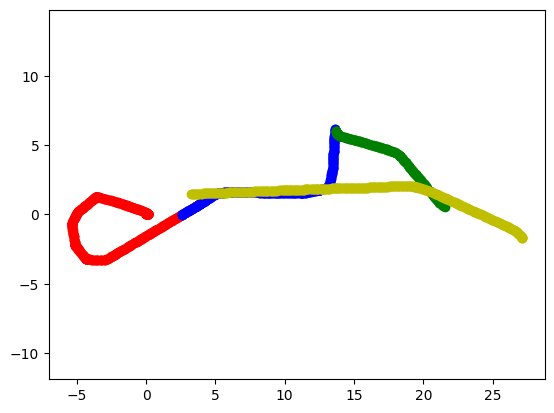

In [47]:
plt.axis('equal')
plt.scatter(arr_1[:, 1], arr_1[:, 2], c="r", label="1")
plt.scatter(arr_2[:, 1], arr_2[:, 2], c="b", label="2")
plt.scatter(arr_3[:, 1], arr_3[:, 2], c="g", label="3")
plt.scatter(arr_4[:, 1], arr_4[:, 2], c="y", label="4")

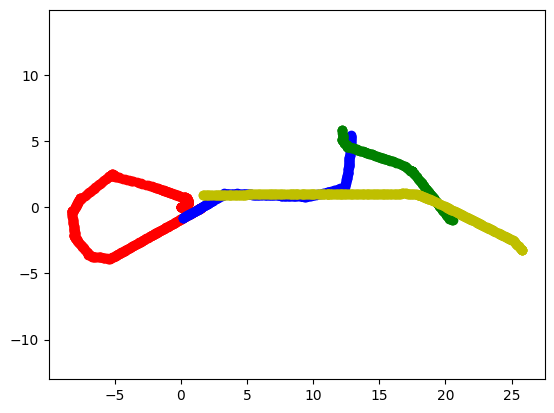

In [48]:
plt.axis('equal')
plt.scatter(arr_1_gt[:, 1], arr_1_gt[:, 2], c='r', label='1')
plt.scatter(arr_2_gt[:, 1], arr_2_gt[:, 2], c='b', label='2')
plt.scatter(arr_3_gt[:, 1], arr_3_gt[:, 2], c='g', label='3')
plt.scatter(arr_4_gt[:, 1], arr_4_gt[:, 2], c='y', label='4')

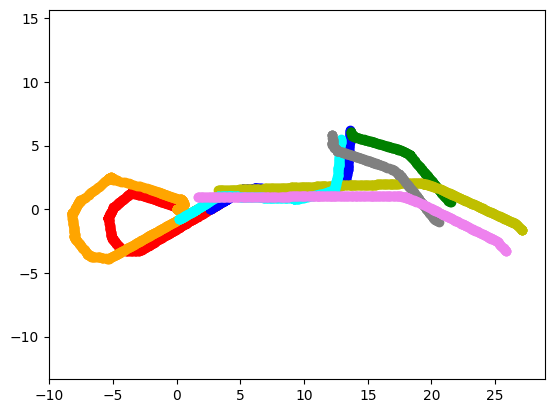

In [49]:
plt.axis('equal')
plt.scatter(arr_1[:, 1], arr_1[:, 2], c="r", label="1")
plt.scatter(arr_2[:, 1], arr_2[:, 2], c="b", label="2")
plt.scatter(arr_3[:, 1], arr_3[:, 2], c="g", label="3")
plt.scatter(arr_4[:, 1], arr_4[:, 2], c="y", label="4")
plt.scatter(arr_1_gt[:, 1], arr_1_gt[:, 2], c="orange", label="1")
plt.scatter(arr_2_gt[:, 1], arr_2_gt[:, 2], c="cyan", label="2")
plt.scatter(arr_3_gt[:, 1], arr_3_gt[:, 2], c="grey", label="3")
plt.scatter(arr_4_gt[:, 1], arr_4_gt[:, 2], c="violet", label="4")

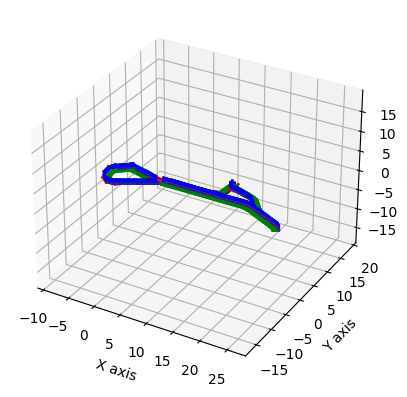

In [50]:
gtsam_plot.plot_incremental_trajectory(1, gt_estimate, time_interval=0.01)
plt.show()


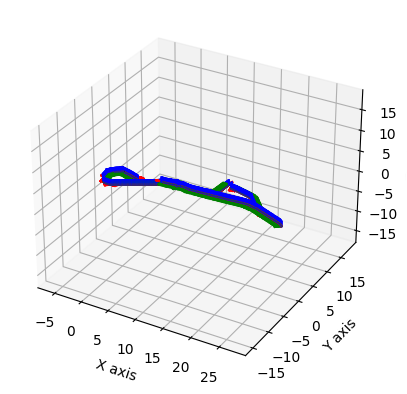

In [51]:
gtsam_plot.plot_incremental_trajectory(1, result_gnc_lm, time_interval=0.01)
plt.show()

In [ ]:
gtsam_plot.plot_incremental_trajectory(1, result_gnc_gauss, time_interval=0.01)
plt.show()

NameError: name 'result_gnc_gauss' is not defined

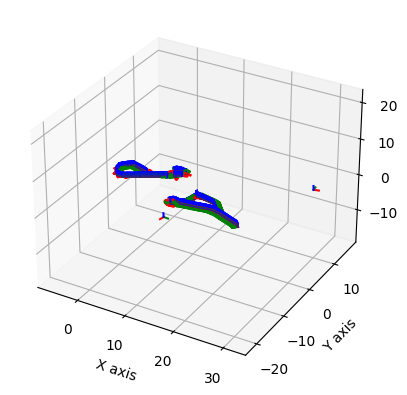

In [52]:
gtsam_plot.plot_incremental_trajectory(1, result_gauss, time_interval=0.01)
plt.show()

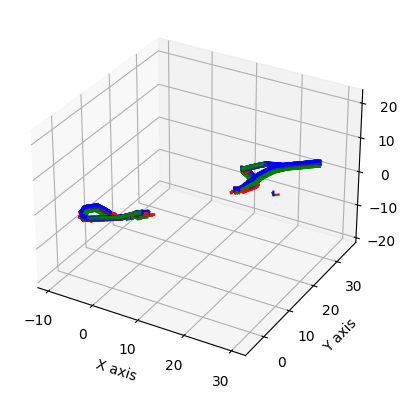

In [53]:
gtsam_plot.plot_incremental_trajectory(1, result_lm, time_interval=0.01)
plt.show()

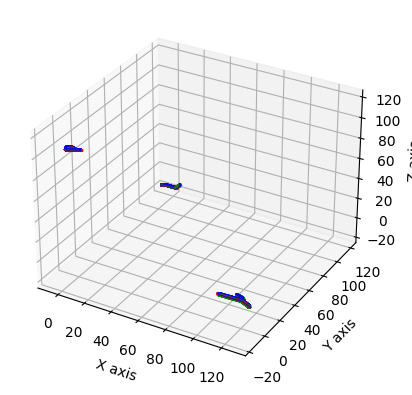

In [54]:
gtsam_plot.plot_incremental_trajectory(1, initial_estimate, time_interval=0.01)
plt.show()

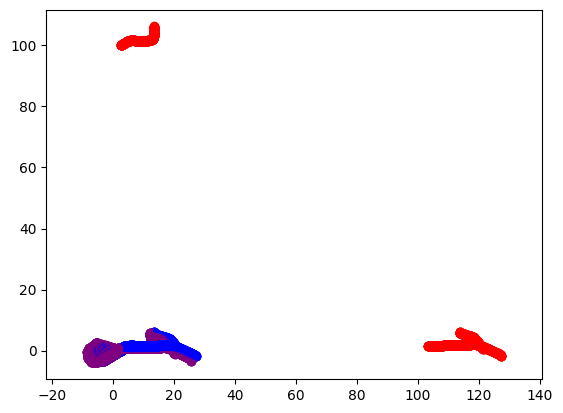

In [55]:
plt.axis('equal')
for i in initial_estimate.keys():
    plt.scatter(initial_estimate.atPose3(i).x(), initial_estimate.atPose3(i).y(), c="r")
    plt.scatter(result_gnc_lm.atPose3(i).x(), result_gnc_lm.atPose3(i).y(), c="b")
    plt.scatter(gt_estimate.atPose3(i).x(), gt_estimate.atPose3(i).y(), c='purple')

In [ ]:
print(graph)

NonlinearFactorGraph: size: 1565

Factor 0: PriorFactor on a0
  prior mean:  R: [
	1, -8.267e-05, 0;
	8.267e-05, 1, 0;
	0, 0, 1
]
t: 2.91004e-05 2.39909e-09           0
  noise model: constrained sigmas [1e-09; 1e-09; 1e-09; 1e-09; 1e-09; 1e-09];
  noise model: constrained mu [1000; 1000; 1000; 1000; 1000; 1000];

Factor 1: BetweenFactor(a0,a1)
  measured:  R: [
	1, -2.00114653e-09, 0;
	2.00114653e-09, 1, 0;
	0, 0, 1
]
t: 2.07934505e-07 2.97600852e-16              0
  noise model: diagonal sigmas [0.01; 0.01; 0.01; 0.05; 0.05; 0.05];

Factor 2: BetweenFactor(a1,a2)
  measured:  R: [
	1, -1.79534687e-10, 0;
	1.79534687e-10, 1, 0;
	0, 0, 1
]
t:   2.0824203e-07 -7.48575922e-17               0
  noise model: diagonal sigmas [0.01; 0.01; 0.01; 0.05; 0.05; 0.05];

Factor 3: BetweenFactor(a2,a3)
  measured:  R: [
	1, -2.00395222e-09, 0;
	2.00395222e-09, 1, 0;
	0, 0, 1
]
t: 4.17379694e-07 9.34387501e-16              0
  noise model: diagonal sigmas [0.01; 0.01; 0.01; 0.05; 0.05; 0.05];

Factor

In [ ]:
graph.saveGraph("test.dot", result_gnc_lm)
import graphviz

graphviz.Source.from_file("test.dot").view()

'test.dot.pdf'

In [ ]:
s = np.array(optimizer_gnc_lm.getWeights())

df = pd.DataFrame(s)
csv_file_path = "/media/baymax/1A52-86C0/new/detected_loops/pose_data/factor_weights.csv"
df.to_csv(csv_file_path, index=False, header=False)



(process:7840): Gtk-WARNING **: 15:03:36.161: Locale not supported by C library.
	Using the fallback 'C' locale.

(evince:7840): Gtk-WARNING **: 15:03:36.194: Theme parsing error: gtk-keys.css:1:0: Failed to import: Error opening file /snap/code/143/usr/share/themes/Default/gtk-3.0/gtk-keys.css: Permission denied
Gtk-Message: 15:03:36.195: Failed to load module "canberra-gtk-module"
Gtk-Message: 15:03:36.196: Failed to load module "canberra-gtk-module"
/home/baymax/snap/code/common/.cache/gio-modules/libdconfsettings.so: cannot open shared object file: Permission denied
Failed to load module: /home/baymax/snap/code/common/.cache/gio-modules/libdconfsettings.so

(evince:7840): Gtk-WARNING **: 15:03:36.255: Could not load a pixbuf from icon theme.
This may indicate that pixbuf loaders or the mime database could not be found.
**
Gtk:ERROR:../../../../gtk/gtkiconhelper.c:494:ensure_surface_for_gicon: assertion failed (error == NULL): Failed to load /usr/share/icons/Yaru/48x48/status/image

Bail out! Gtk:ERROR:../../../../gtk/gtkiconhelper.c:494:ensure_surface_for_gicon: assertion failed (error == NULL): Failed to load /usr/share/icons/Yaru/48x48/status/image-missing.png: Unable to load image-loading module: /snap/code/143/usr/lib/x86_64-linux-gnu/gdk-pixbuf-2.0/2.10.0/loaders/libpixbufloader-png.so: /snap/code/143/usr/lib/x86_64-linux-gnu/gdk-pixbuf-2.0/2.10.0/loaders/libpixbufloader-png.so: cannot open shared object file: Permission denied (gdk-pixbuf-error-quark, 5)
